# Source variability (no. of source samples on source identification accuracy) demonstration

This assessment of source sample size on source identification accuracy uses a test dataset which contains 5 samples each from bats, cows, and humans (sewage) for demonstration purposes. The relevant datasets, including mapping files, and feature count tables in both .biom and .tsv format. Please note that these files have been pre-processed using QIIME2, and rarefied using a sampling depth of 2,000.

The files are located in **Bioinformatics-IlluminaMGI/16S/Source variability/Demo/Test_dataset/**

**Step 1 is to generate modified metadata using random sampling method, in which from source sample size n = 1 to n = N-1, the n samples from a source type will be randomly sampled by the designated _draw number_ with replacement at each draw to be sources (along with samples from other source types), while the rest of the samples not selected as sources will be set as sink.**

In [1]:
#This is to generate metadata using random sampling method

#import relevant libraries
import os
import pandas as pd
import numpy as np

def source_variability(metadata_path, save_path, draw_number):
    '''    

    Parameters
    ----------
    metadata_path : location of the metadata files (need to have different metadata files for each animal)
    save_path : Location to save modified metadata
    draw_number: Number of times you want to randomly sample the samples that are picked as sources

    Returns
    -------
    files in save_path

    '''
   
    #obtain unique animal names, and sizes
    df = pd.read_csv(metadata_path, sep="\t")
    animal_names = df["Env"].unique() #obtain unique animal names
    size_animal = df.groupby(["Env"]).size() #obtain size of animal
    #print(size_animal)
    
    #get current animal name in loop
    for i in range(0,len(animal_names)):
        current_animal = animal_names[i] #current animal name in loop
        #print (current_animal)
        
        #get current number of animal which needs to be randomly selected
        for j in range(1,size_animal.loc[current_animal]):
           #print (j)           
           
           #randomly select samples to be changed as sinks in metadata
           for k in range(0,no_of_draws):
               df = pd.read_csv(metadata_path, sep="\t")
               no_of_sinks = size_animal.loc[current_animal] - j
               _index = df[df["Env"] == current_animal].index
               #print (_index)
               rand = np.random.choice(_index, size = no_of_sinks, replace = False)
               #print (rand)
               #print(df.loc(current_animal))
               df.iloc[[rand],2] = 'sink' #make reciprocal change, eg. if only test with one sample, the rest change to sink
               namefile = current_animal
               with open("./Test_dataset/Modified_metadata/%s_%sSources_DrawNo%s.txt" %(namefile,j,k+1), 'w') as f:
                   dfAsString = df.to_csv(index=False,sep="\t")
                   f.write(dfAsString)

                   
    print ('Metadata has been generated and saved')
               

if __name__=='__main__':
    metadata_path = "./Test_dataset/Mapping_files_demo.txt"
    save_path = "./Test_dataset/Modified_metadata"
    no_of_draws = 10
    source_variability(metadata_path, save_path, no_of_draws)    


Metadata has been generated and saved


**Step 2 is to generate shell script (.sh) that contains a list of sourcetracker commands.**

In [3]:
#import relevant libraries
import os

#change directory for the modified metadata to be saved
files = os.listdir("./Test_dataset/Modified_metadata")
namefile= [os.path.splitext(filename)[0] for filename in os.listdir("./Test_dataset/Modified_metadata")]
#print (files)
#print (namefile)


#use nested for loop, first run 5 times, then switch to another metadata file for the entire range of the loop
for x in range(len(files)):
    for runs in range(1,6):    
        script = 'sourcetracker2 gibbs -i ./Test_dataset/Modified_metadata/feature-table.tsv -m ./Test_dataset/Modified_metadata/%s -o ./SourceTracker_Exports/%s_r%s --burnin 100 --source_rarefaction_depth 2000 --sink_rarefaction_depth 2000 \n' %(files[x],namefile[x],runs)
        with open("./Test_dataset/Shell script/ST_sinkswitch_16S.txt",'a') as f:
                f.write (script)
        
print ('Script has been written and you need to request session in HPC (if available) and load sourcetracker. It''s best to upload the .txt file to a website that converts text files from DOS line endings to Unix line endings, i.e., Dos2Unix. Please also make sure to change the .txt to .sh after converting Dos line endings to Unix line endings.')       
# After file has been written, upload the txt file to https://www.fileformat.info/convert/text/dos2unix.tr (Dos2Unix to solve \n issue)

Script has been written and you need to request session in HPC (if available) and load sourcetracker. Its best to upload the .txt file to a website that converts text files from DOS line endings to Unix line endings, i.e., Dos2Unix. Please also make sure to change the .txt to .sh after converting Dos line endings to Unix line endings.


**The output should look something like this:**

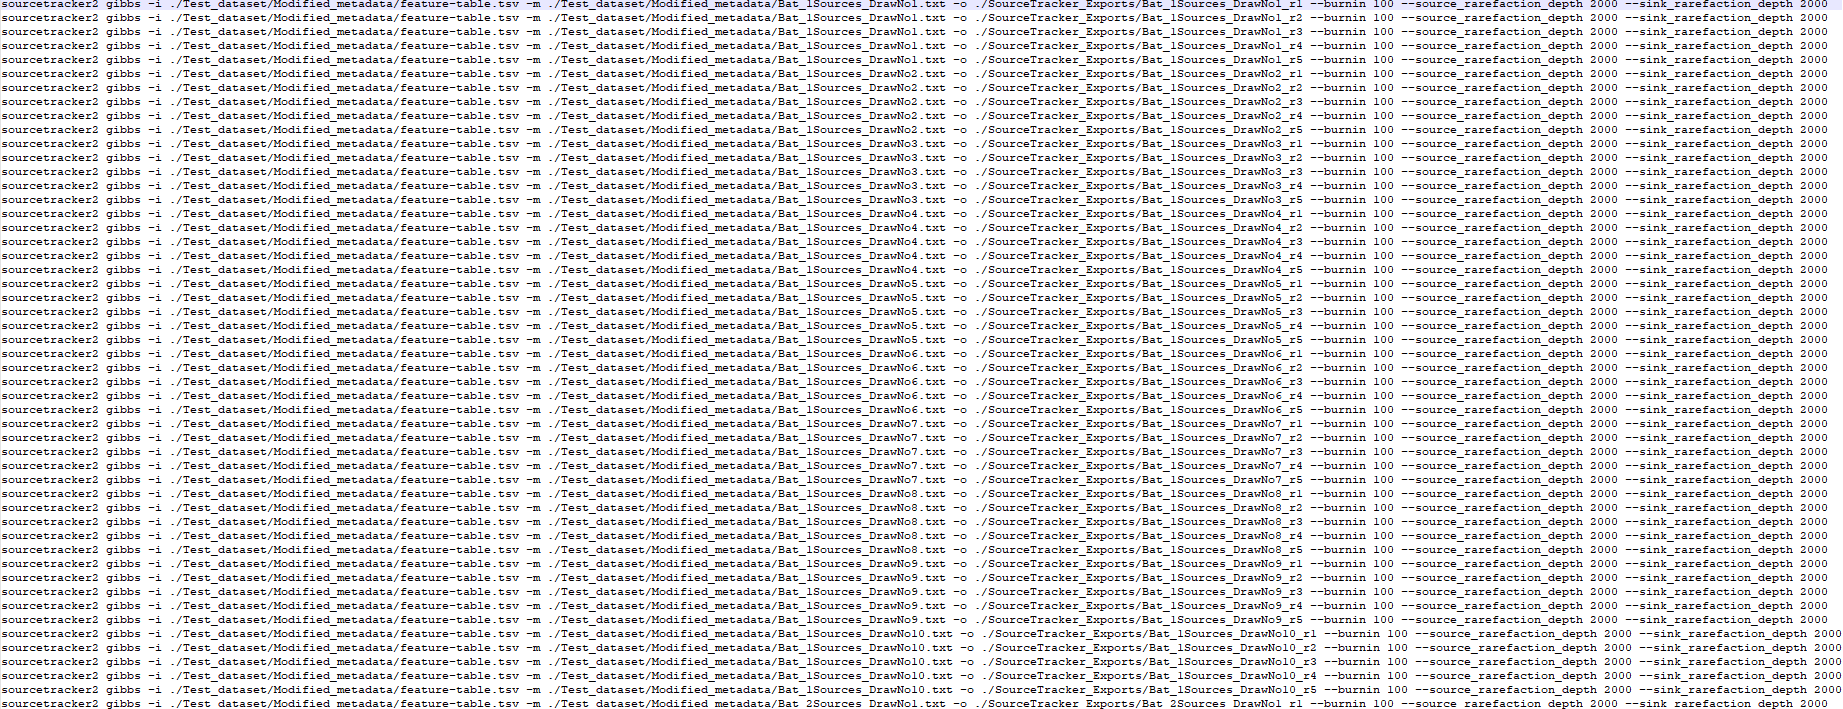

***If submitting as shell script, make sure to add #!/bin/bash and load sourcetracker module to the top of shell script. It should look something like this, but please adjust this as per your HPC/system:***

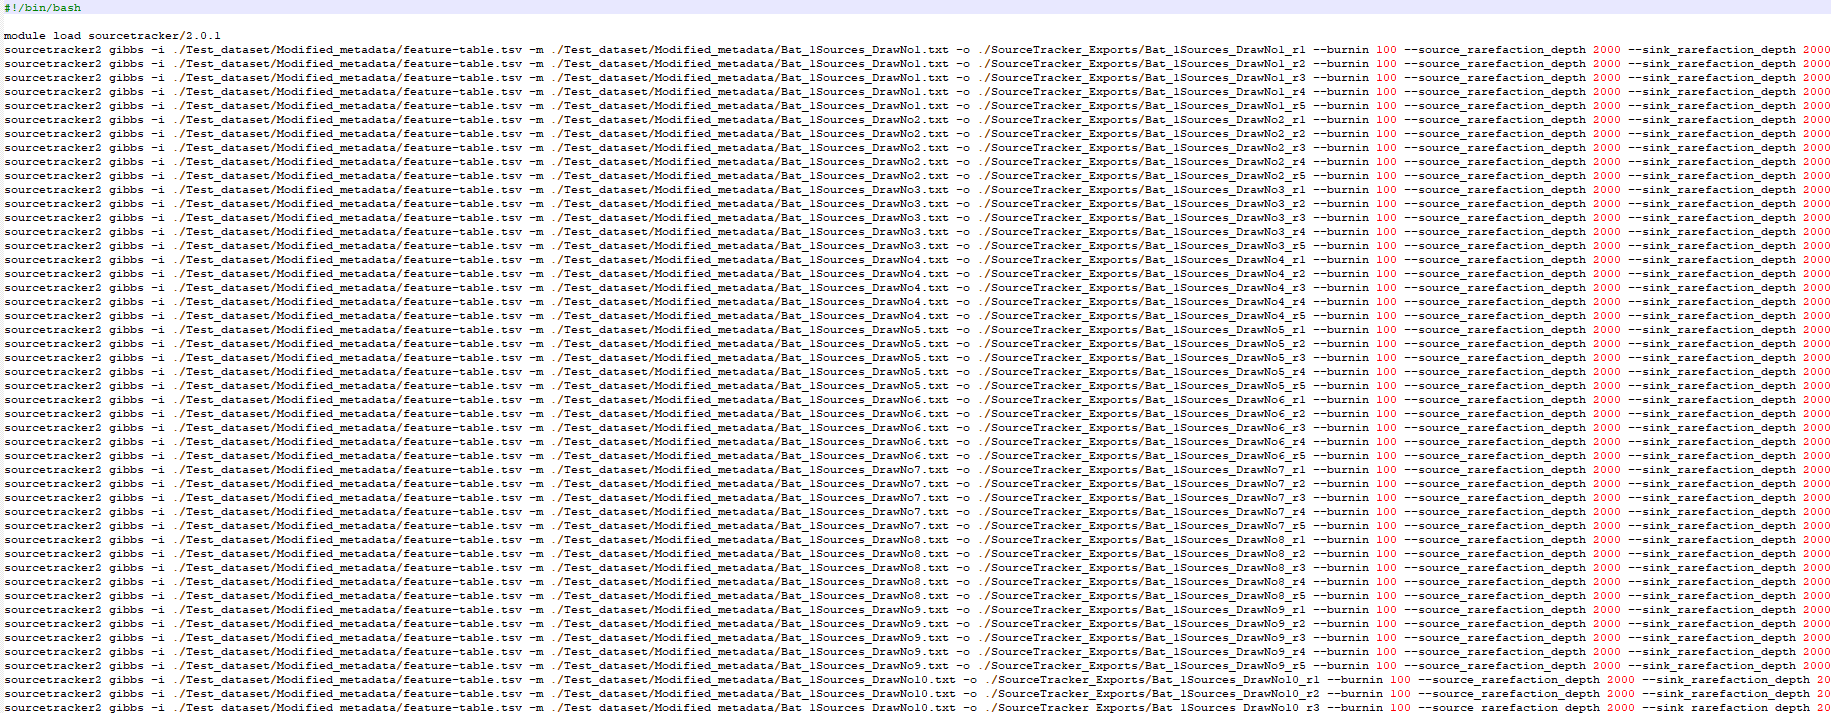

**Once SourceTracker runs have been completed, download the export folder (for this demonstration purposes the files have been saved in Bioinformatics-IlluminaMGI/16S/Source variability/Demo/SourceTracker_Exports/) which contains all the results for each of the runs.** 

**As there might be glitches and may result in some results not recorded, Step 3 is to then identify runs which have missing _mixing_proportions.txt_ file within the export folder. If there is no folders listed within the _missing_files.txt_, that means the runs have been successfully completed.**

In [1]:
import os

def find_folders_missing_file(directory, target_file):
    # List to store the folders missing the target file
    missing_folders = []
    
    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Check if the target file is in the current folder
        if target_file not in files:
            # If the target file is missing, add the folder to the list
            missing_folders.append(root)
    
    return missing_folders

def write_missing_folders_to_file(missing_folders, output_file):
    with open(output_file, 'w') as f:
        for folder in missing_folders:
            f.write(folder + '\n')

def main():
    directory = "./Test_dataset/SourceTracker_Exports"  # Replace with the path to your directory
    target_file = 'mixing_proportions.txt'
    output_file = './Test_dataset/Metadata_for_compilation/missing_files.txt'
    
    missing_folders = find_folders_missing_file(directory, target_file)
    write_missing_folders_to_file(missing_folders, output_file)
    print(f'List of folders missing {target_file} has been written to {output_file}')

if __name__ == "__main__":
    main()


List of folders missing mixing_proportions.txt has been written to ./Test_dataset/Metadata_for_compilation/missing_files.txt


**Step 4 is to then generate metadata file which will be used for compilation of results.**

In [3]:
#import relevant libraries
import os

#change directory for the modified metadata to be saved
files = os.listdir("./Test_dataset/Modified_metadata")
namefile= [os.path.splitext(filename)[0] for filename in os.listdir("./Test_dataset/Modified_metadata")]
#print (files)
#print (namefile)

       
#use nested for loop, first run 5 times, then switch to another metadata file for the entire range of the loop
for x in range(len(files)):
    for runs in range(1,2):    
        script = '%s\n' %(namefile[x])
        with open("./Test_dataset/Metadata_for_compilation/ST_sinkswitch_16S_Source.txt",'a') as f:
                f.write (script)
        
print ('Metadata file has been generated. This file lists "#SampleID", which contains information regarding source type, no. of samples included, and the draw number. You need to manually modify the file to be in SourceTracker metadata file format by inserting Env and SourceSink column. The Env column should be a duplicate of the "#SampleID" column, while the SourceSink can be either source or sink -- defining either sink or source will not impact the output.')       


Metadata file has been generated. This file lists "#SampleID", which contains information regarding source type, no. of samples included, and the draw number. You need to manually modify the file to be in SourceTracker metadata file format by inserting Env and SourceSink column. The Env column should be a duplicate of the "#SampleID" column, while the SourceSink can be either source or sink -- defining either sink or source will not impact the output.


**As per the instructions shown by output of Step 4, you will need to manually modify the file. An example has been included under _Bioinformatics-IlluminaMGI/16S/Source variability/Demo/Test_dataset/Metadata_for_compilation/ST_sinkswitch_16S_Source.txt_, with a snippet from the file taken shown below:**

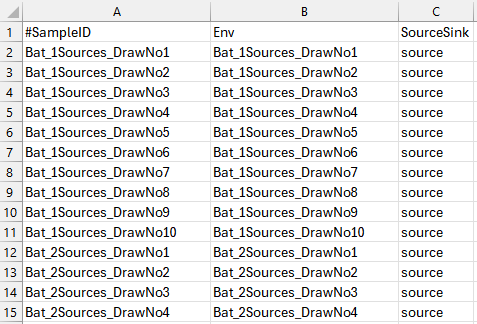

**Step 4 is to compile the results by running the script below.**

In [7]:
import os
import pandas as pd

def tread_data(files_path, env_file_path, save_path):
    '''
    This function is used to intergate the txt files into one csv file.
    The data structure need to follow **SourceTracker**
    '''
    files = os.listdir(files_path)
    #####Get ########
    with open(env_file_path,'r') as f:
        env = f.readlines()
    for i, _ in enumerate(env):
        if _ == '\n':
            env.pop(i)
    env.pop(0)
    #####Get the date and ENV#######
    dateWenv_list = []
    for i in env:
        _data, _env,_ = i.split('\t')
        dateWenv_list.append(
            {
                'Sample_ID':_data,
                'env':_env
            }
        )
    #####get the files#####
    for i in dateWenv_list:
        _list = []
        for j in files:
            if i['Sample_ID'] == j[:-3]:
                _list.append(j)
        _list.sort(key= lambda a:int(a.split('_r')[-1])) 
        i['files_name'] = _list

    data_list = []
    k = 0
    for i in dateWenv_list:
        env = i['env']
        for j in i['files_name']:
            fp = os.path.join(
                files_path,
                j
            )
            df = pd.read_csv(
                os.path.join(
                    fp,
                    'mixing_proportions.txt'
                ),
                delimiter = '\t'
            )
            df_std = pd.read_csv(
                os.path.join(
                    fp,
                    'mixing_proportions_stds.txt'
                ),
                delimiter = '\t'
            )
            k = k + 1
            #print (k) #Remove comment "#" before "print (k)" for Debugging purposes
            df.insert(
                0,
                'Env',
                env
            )
            df.insert(
                0,
                'FolderName',
                j
            )
            df.insert(
                0,
                'run',
                j.split('_r')[-1]
            )
            

            df_std = df_std.drop(columns=['SampleID'])
            #get colums index
            
            for i in df_std.columns.values:
                df_std = df_std.rename(columns={i:i+'_std'})

            data_list.append(
                pd.concat([df,df_std], axis=1)
            )

    all1one = pd.concat(data_list)
    print ("Results have been compiled.")
    all1one.to_csv(
        os.path.join(
            save_path,
            'Source_variability_demo_compilation.csv'
        )     
    )



if __name__=='__main__':
    files_path = "./SourceTracker_Exports"
    env_file_path = './Test_dataset/Metadata_for_compilation/ST_sinkswitch_16S_Source.txt'
    save_path = "./Results"
    tread_data(files_path, env_file_path, save_path)    

Results have been compiled.


**Once the results have been compiled, save the .csv file as .xlsx file. Then, manually re-organise/sort the results, by first sorting the raw results in terms of SampleID (so that it is easier to compile the average of 5 SourceTracker replicate runs for each run). Using the test dataset, the re-organised results have been included in _Bioinformatics-IlluminaMGI/16S/Source variability/Demo/Results/Source_variability_demo_compilation.xlsx_. You may use this file as a template to manually re-organise your results.**

**It is advisable to copy the _Filter1_CopyAsValues_ worksheet into a new spreadsheet file and work from there for data tabulation and visualisation purposes, as working with huge amount of data may overload the spreadsheet program (e.g., Microsoft Excel), causing it to crash. An example of this has been included in _Bioinformatics-IlluminaMGI/16S/Source variability/Demo/Results/Source_variability_demo_compilation_summary.xlsx_.**

**Similar to LOO, samples are deemed to be incorrectly assigned if the highest contribution (apart from unknown %) is from a source other than when it was identified during collection. Using this, we can then determine the identification accuracy for each source sample size (n), based on the amount of samples which have been incorrectly identified. The following screenshots show example of incorrectly assigned sample, including how they impact the calculation of identification accuracy:**

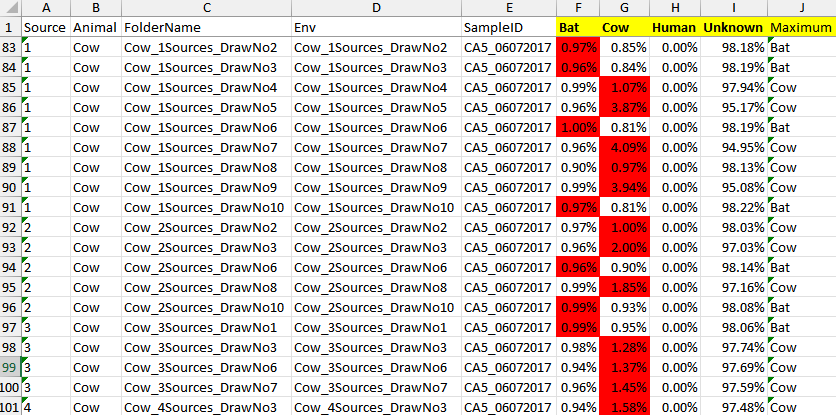

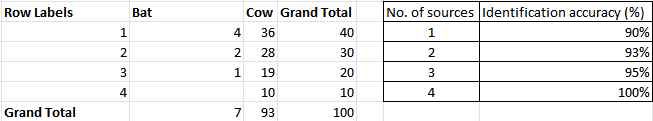



**As an example, based on the test dataset, we have included a plot of identification accuracy against no. of source samples included:**

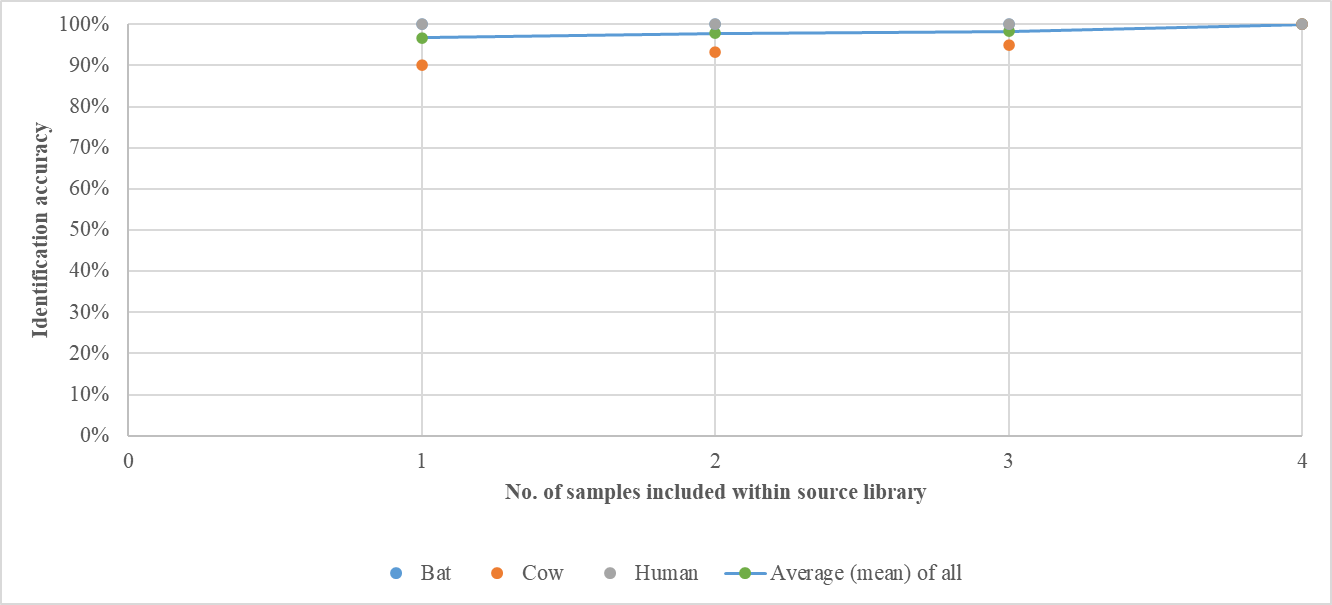